In [1]:
! pip install autogluon

     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 273 kB 63.4 MB/s 
     |████████████████████████████████| 352 kB 59.4 MB/s 
     |████████████████████████████████| 206 kB 47.3 MB/s 
     |████████████████████████████████| 131 kB 54.7 MB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
     |████████████████████████████████| 4.2 MB 30.7 MB/s 
     |████████████████████████████████| 802 kB 59.1 MB/s 
     |████████████████████████████████| 27.4 MB 1.5 MB/s 
     |████████████████████████████████| 119 kB 59.1 MB/s 
     |████████████████████████████████| 1.3 MB 47.6 MB/s 
     |████████████████████████████████| 3.0 MB 46.0 MB/s 
     |████████████████████████████████| 296 kB 56.9 MB/s 
     |████████████████████████████████| 166.7 MB 17 kB/s 
     |████████████████████████████████| 67.3 MB 13 kB/s 
     |████████████████████████████████| 189 kB 73.5 MB/s 
     |█████████████

In [73]:
! pip install phate

     |████████████████████████████████| 416 kB 8.6 MB/s 
     |████████████████████████████████| 104 kB 51.7 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 1.8 MB 45.3 MB/s 


In [2]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data

from tensorflow import keras

from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Bidirectional, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Add

In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import SimpleRNN, LSTM

In [4]:
from tensorflow import convert_to_tensor
import tensorflow as tf

In [75]:
# genomics-specific visualization tools
import phate
import scprep

from sklearn.manifold import TSNE

import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [84]:
from pathlib import Path

DATA = Path("/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project")

In [85]:
import sys
sys.path.append(DATA)

In [86]:
%cd /gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project

/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project


In [87]:
# .py file created with helper functions
from utils import *

## Load Data and Clean it

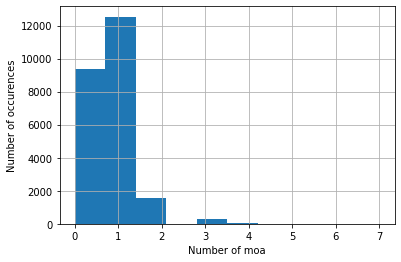

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=None)
StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.7,
            train_size=None)


In [10]:
# load data
df_feature, df_labels, df_raw = read_data(path)

# get number of moa per row, and plot histogram
n_moa = get_n_moa(df_labels)
get_plot_n_moa(df_labels)

# remove labels that occur less than min_label_occur param
sel_labels, sel_raw = sel_labels_by_occur(df_labels, df_raw, min_label_occur=100)
# remove ids that have more than 1 moa or less than 1 moa
n_moa_feature, n_moa_labels = get_n_moa_per_row(df_feature, sel_labels, n_moa_per_row=1)
# split data into test train and val
df_feat, df_lab = get_test_train_val(n_moa_feature, n_moa_labels)
# get split labels, make them categories (int) instead of hot encoded
train_labels, test_labels, val_labels = split_labels_train_test_val(df_lab)
# get split features in pandas DataFrame
train_features, test_features, val_features = split_features_train_test_val(df_feat, in_numpy=False)
# get split features in numpy ndarray
nptrain_features, nptest_features, npval_features = split_features_train_test_val(df_feat, in_numpy=True)

In [133]:
def get_gene_exp_features(df_feature, in_numpy=False):
    """Makes feature pd.DataFrame into numpy array with floats and ints only

    Parameters
    ----------
    df_feature : `pd.DataFrame`
        features pandas data frame
    in_numpy : `bool`
        if features should be returned in numpy, with integers and floats only 
        (True) or in pd.DataFrame (False)
        Defaults to False.

    Returns
    -------
    gene_feature : `np.ndarray`
        Gene expression features nd array
    """
    gene_cols = [col for col in df_feature.columns if (col.startswith('g-')|col.startswith('id'))]
    gene_feature = df_feature[gene_cols]
    if in_numpy == True:
        if np.isin('id', gene_feature.columns):
            gene_feature = gene_feature.drop(columns=['id'])
        if np.isin('dtype', gene_feature.columns):
            gene_feature = gene_feature.drop(columns=['dtype'])
        gene_feature = gene_feature.to_numpy()
        
    return gene_feature

def get_labels_ordinal(df_labels):
    """Returns train, test and validation sets of labels, no longer hot encoded

    Parameters
    ----------
    df_labels : `pd.DataFrame`
        hot encoded labels pandas data frame

    Returns
    -------
    ordinal_labels : 1D `np.array` 
        labels, in integers (NOT hot encoded)
    """ 
    if np.isin('id', df_labels.columns):
        df_labels = df_labels.drop(columns=['id'])
    if np.isin('dtype', df_labels.columns):
        df_labels = df_labels.drop(columns=['dtype'])
    ordinal_labels = np.argmax(df_labels.to_numpy(), axis=1)
    
    return ordinal_labels

In [112]:
# get gene expression only
gene_exp_feat = get_gene_exp_features(df_feature, in_numpy=False)
npgene_exp_feat = get_gene_exp_features(df_feature, in_numpy=True)

In [113]:
# see if it worked properly
gene_exp_feat.head()

,id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,-0.9041,-0.8089,0.6598,-0.4772,0.1289,-0.0297,0.4564,-0.1447,0.4683,-0.1722,0.9998,1.2860,-0.6166,0.0963,1.6340,-0.8744,0.4931,-0.0283,-0.3110,-0.1117,-0.4528,1.3240,-0.0503,-1.2750,-0.1750,-0.6972,-0.2720,0.2931,1.5280,0.3453,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,-0.2568,...,3.1050,0.0204,-0.0961,0.2919,-0.4584,0.0556,0.9844,-0.6653,-0.3092,-0.1507,-0.9481,-0.1966,0.8554,0.5839,-1.6840,0.0648,0.5845,0.0891,-0.5025,-0.1047,0.3764,-1.4800,-0.2947,0.2745,-0.5234,0.1575,-0.1214,0.0476,0.1657,1.0310,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,5.4470,...,-0.4954,-0.1840,-1.1110,-0.5649,-0.2617,2.9120,2.7720,0.1523,-1.1230,-0.5340,-0.7937,0.3457,-0.6136,-0.0706,-0.7474,0.1795,-0.4674,-0.1552,0.6338,0.5130,-0.3625,0.0873,0.2689,-0.2174,0.7069,-0.6456,0.6822,0.2237,-0.3601,1.2780,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,3.0900,...,0.2239,0.4428,-0.2822,-0.8175,1.4930,-0.0711,-1.6250,-0.4317,-0.0239,0.5046,-0.8061,0.9736,1.2540,2.0730,0.6604,-0.4758,-0.1766,-0.8959,0.6560,-0.0875,0.1082,-0.7158,0.0712,-0.1939,0.4286,-1.0220,0.9017,1.1750,-0.5760,0.7801,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,...,-0.2094,1.1270,0.1874,-0.0465,1.0560,-0.6324,-0.3651,0.9485,-0.6745,0.0479,-1.0470,-1.2440,-0.7675,0.2327,0.3698,1.4900,0.3632,1.4380,-0.5047,-0.2092,-0.4386,-1.1780,0.8236,1.0540,0.6745,-0.6354,-0.6745,-1.3780,0.7521,-0.9456,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269


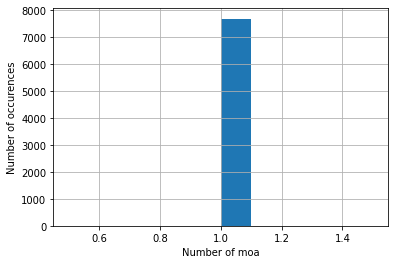

In [72]:
# n_moa post-selection
get_plot_n_moa(n_moa_labels);

In [51]:
temp = (np.argmax(n_moa_labels.drop(columns=['id', 'dtype']).to_numpy(), axis=0))
temp
# np.argmax(train_labels, axis=1)

array([ 6,  8, 11, ..., 36, 30,  8])

In [151]:
# these are our labels
moa_label_names = pd.Series(list(n_moa_labels.drop(columns=['id', 'dtype']).columns))
moa_label_names.values

array(['acetylcholine_receptor_agonist',
       'acetylcholine_receptor_antagonist', 'adrenergic_receptor_agonist',
       'adrenergic_receptor_antagonist',
       'bacterial_cell_wall_synthesis_inhibitor',
       'bacterial_dna_inhibitor', 'calcium_channel_blocker',
       'cc_chemokine_receptor_antagonist', 'cdk_inhibitor',
       'cyclooxygenase_inhibitor', 'cytochrome_p450_inhibitor',
       'dna_inhibitor', 'dopamine_receptor_agonist',
       'dopamine_receptor_antagonist', 'egfr_inhibitor',
       'estrogen_receptor_agonist', 'flt3_inhibitor',
       'gaba_receptor_agonist', 'gaba_receptor_antagonist',
       'glucocorticoid_receptor_agonist', 'glutamate_receptor_antagonist',
       'hdac_inhibitor', 'histamine_receptor_antagonist',
       'hmgcr_inhibitor', 'kit_inhibitor', 'mtor_inhibitor',
       'nfkb_inhibitor', 'pdgfr_inhibitor', 'phosphodiesterase_inhibitor',
       'pi3k_inhibitor', 'ppar_receptor_agonist',
       'progesterone_receptor_agonist', 'proteasome_inhibitor',
 

In [14]:
# check how many labels we have, and their counts
np.unique(train_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 array([ 91, 147, 128, 171,  87,  54, 127,  52, 175, 204,  41, 176,  50,
        163, 159,  67,  28,  42,  69, 122, 176,  52, 111, 129,   3,  40,
         46,   8, 119,  51,  50,  43,   5,  40, 106, 111, 144, 129,  52,
        150,  40]))

In [11]:
# showing that the split worked
n_moa_labels['dtype'].value_counts()

train    3758
test     3244
val       692
Name: dtype, dtype: int64

In [12]:
# dimensions of test/train/val data
print(f'Train, test, val labels {(train_labels.shape, test_labels.shape, val_labels.shape)}')
print(f'Train, test, val features {(train_features.shape, test_features.shape, val_features.shape)}')

Train, test, val labels ((3758,), (3244,), (692,))
Train, test, val features ((3758, 876), (3244, 876), (692, 876))


## Data Visualization

In [134]:
# nnptrain_features, nnptest_features, nnpval_features = split_features_train_test_val(df_feat.dropna(), in_numpy=True)
npgene_exp_feat = get_gene_exp_features(n_moa_feature, in_numpy=True)
# get ordinal labels
ordinal_labels = get_labels_ordinal(n_moa_labels)
# get moas of ordinal labels
name_labels = list(moa_label_names[ordinal_labels.astype(int)].values)

In [136]:
# https://www.nature.com/articles/s41587-019-0336-3
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(npgene_exp_feat)

Calculating PHATE...
  Running PHATE on 7694 observations and 772 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.41 seconds.
    Calculating KNN search...
    Calculated KNN search in 9.39 seconds.
    Calculating affinities...
    Calculated affinities in 1.78 seconds.
  Calculated graph and diffusion operator in 12.62 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.68 seconds.
    Calculating KMeans...
    Calculated KMeans in 27.81 seconds.
  Calculated landmark operator in 30.92 seconds.
  Calculating optimal t...
    Automatically selected t = 40
  Calculated optimal t in 5.61 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.84 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.91 seconds.
Calculated PHATE in 60.94 seconds.


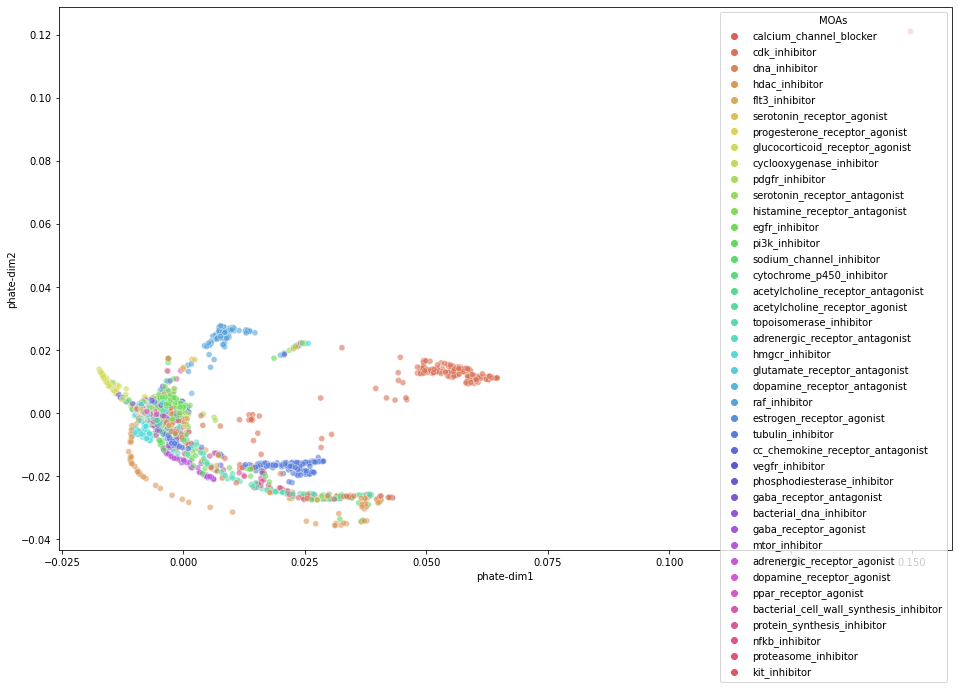

In [168]:
phate_df = pd.DataFrame()
phate_df['MOAs'] = list(moa_label_names[ordinal_labels.astype(int)].values)
phate_df['phate-dim1'] = data_phate[:,0]
phate_df['phate-dim2'] = data_phate[:,1]

plt.figure(figsize=(16,10))
plot_phate1 = sns.scatterplot(
    x="phate-dim1", y="phate-dim2",
    hue="MOAs",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=phate_df,
    legend="full",
    alpha=0.6
)
plot_tsne.legend(loc='center left', bbox_to_anchor=(1.6, 0.5), ncol=1)

<Figure size 1152x720 with 0 Axes>

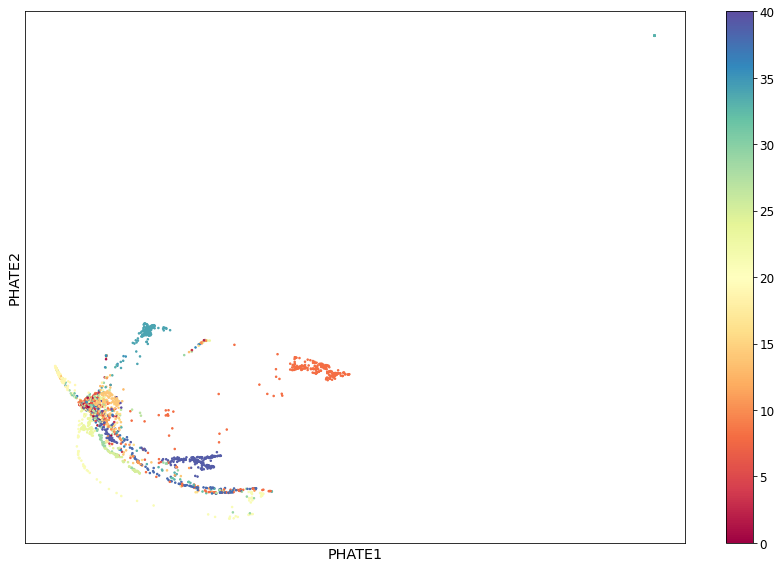

In [167]:
plt.figure(figsize=(16,10))
plot_phate2 = scprep.plot.scatter2d(data_phate, c=ordinal_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [ ]:
# t-SNE
tsne = TSNE(verbose = 2)
tsne_results = tsne.fit_transform(npgene_exp_feat)

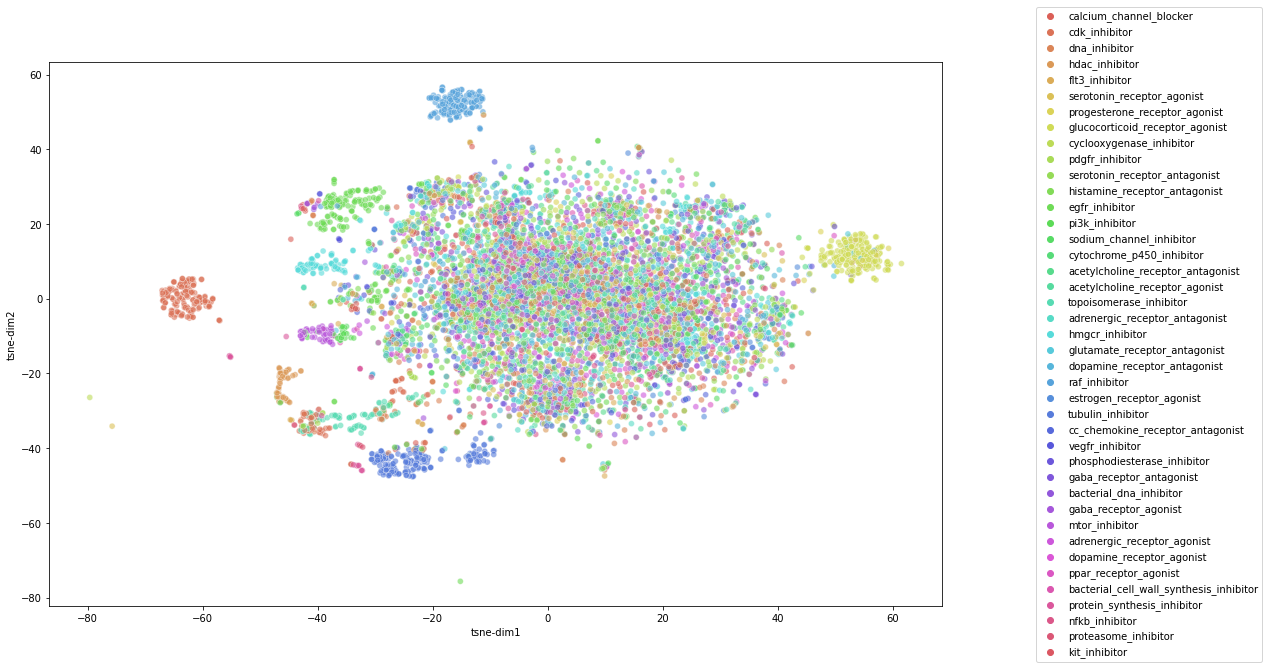

In [154]:
# Plot lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = list(moa_label_names[ordinal_labels.astype(int)].values)
tsne_df['tsne-dim1'] = tsne_results[:,0]
tsne_df['tsne-dim2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
plot_tsne = sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plot_tsne.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

## Prediction model
### 1. Autogluon
### 2. Neural Network
* 1 to 4 convolutional neural network (CNN) layers
* 1 to 2 bidirectional recurrent neural network (RNN) layers
* 1 to 2 fully connected (FC) layers, in a global architecture layout CNN-RNN-FC

In [15]:
train_features['label'] = train_labels

In [25]:
save_path = 'autogluon_model'  # specifies folder to store trained models
predictor = TabularPredictor(label='label', path=DATA/save_path).fit(train_features)

Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    3758
Train Data Columns: 876
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 41) unique label values:  [8, 31, 6, 20, 3, 15, 12, 21, 9, 37]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 10 examples that will be kept for training models: 0.9957424161788185
Train Data Class Count: 38
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11418.07 MB
	Train Data (Original)  Memory Usage: 26.61 MB (0.2% of a

In [23]:
save_path = 'autogluon_model'

In [26]:
predictor = TabularPredictor.load(save_path)
y_pred = predictor.predict(test_features)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=pd.Series(test_labels), y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.8504932182490752
Evaluations on test data:
{
    "accuracy": 0.8504932182490752,
    "balanced_accuracy": 0.7784825340534945,
    "mcc": 0.8457605099047497
}


Predictions:  
 0        6
1       11
2       21
3       16
4       11
        ..
3239     8
3240     4
3241    36
3242    30
3243     8
Name: label, Length: 3244, dtype: int64


#### Plot confusion matrix for Autogluon

In [37]:
cm = confusion_matrix(pd.Series(test_labels), y_pred)

In [68]:
# get confusion matrix for predictions
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(n_moa_labels.drop(columns=['id', 'dtype']).columns))

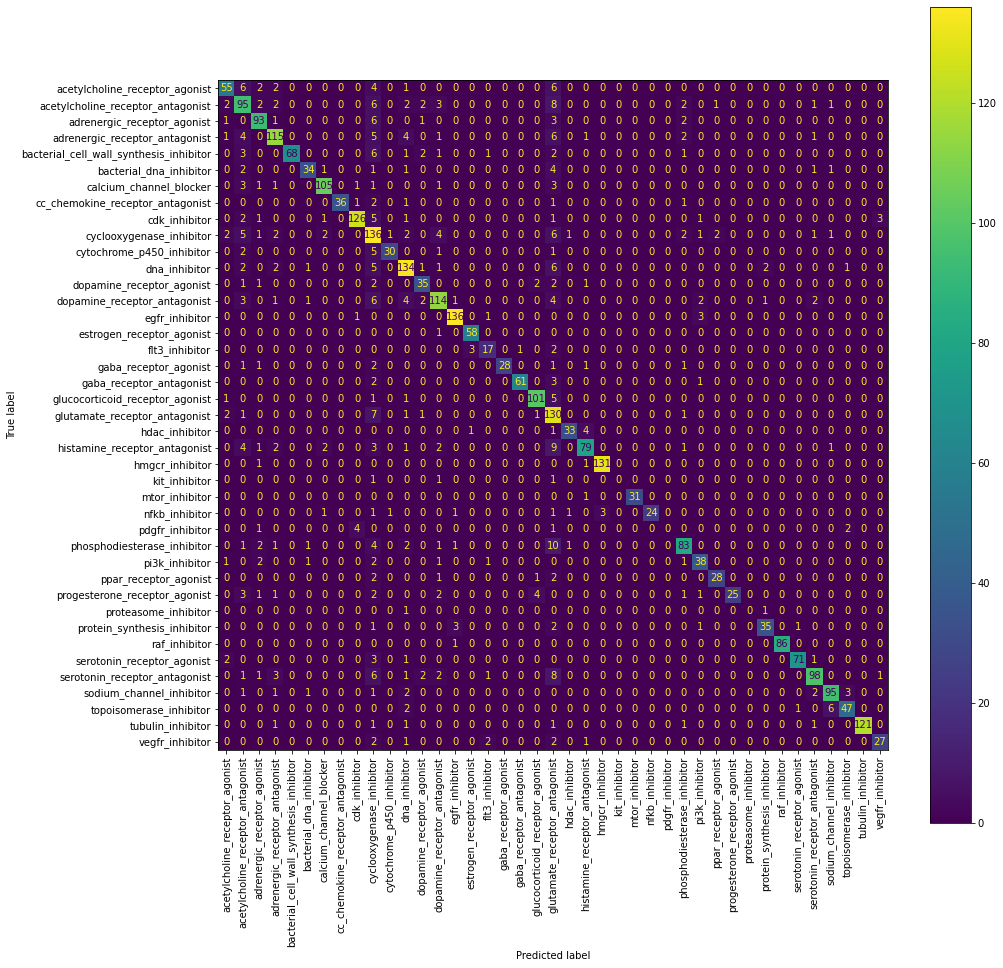

In [69]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
ig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp1 = disp.plot(ax=ax, xticks_rotation = 'vertical')

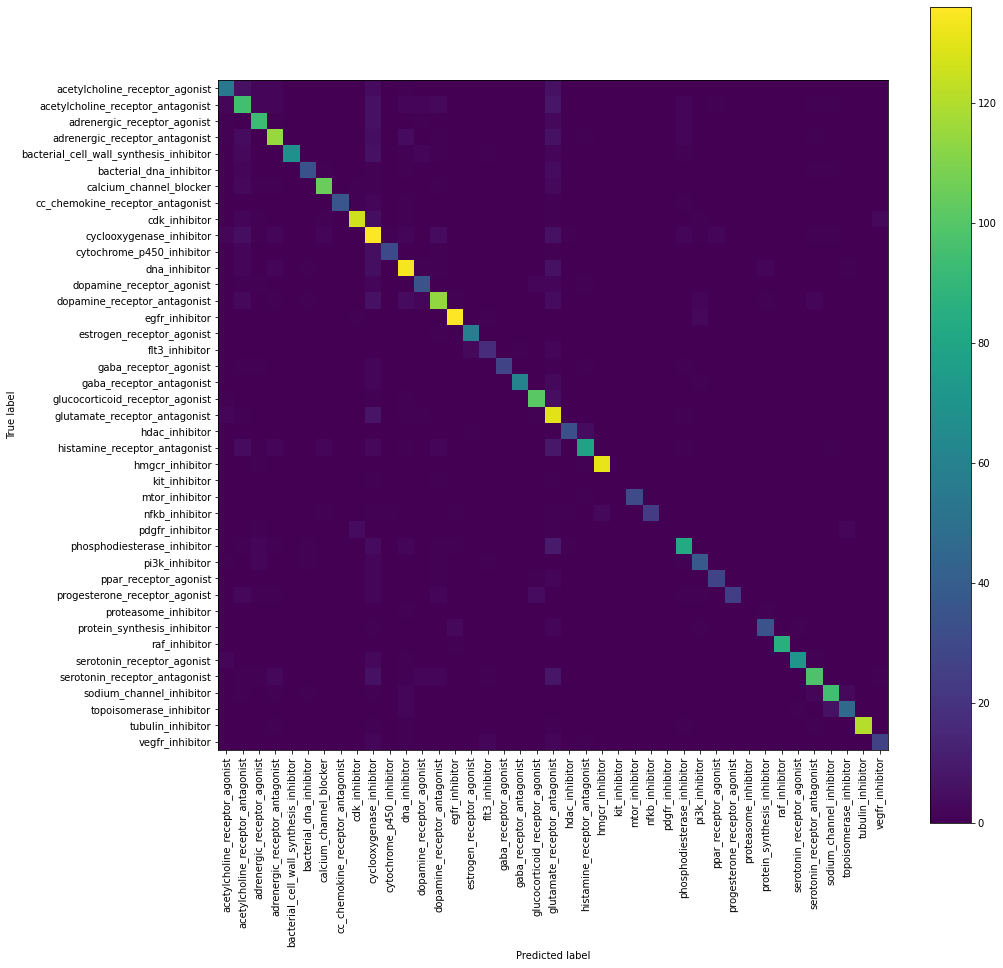

In [70]:
# plot confusion matrix
ig, ax2 = plt.subplots(figsize=(15, 15))
disp2 = disp.plot(include_values=False, ax=ax2, xticks_rotation = 'vertical')

In [29]:
def bi_LSTM(x_train,y_train):
    inputs=Input(shape=(x_train[0].shape), name='inputs')
    
    dense1 = Dense(32, activation='relu')(inputs)
    biLSTM1 = Bidirectional(LSTM(128))(dense1)
    drop1 = Dropout(0.3)(biLSTM1)
    bn1 = BatchNormalization()(drop1)
    dense2 = Dense(64, activation='relu')(bn1)
    drop2 = Dropout(0.3)(dense2)
    bn2 = BatchNormalization()(drop2)
    main_output = Dense(1, activation='softmax')(bn2)

    model = Model(inputs= inputs, outputs=main_output, name='BiLSTM_Model')
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [18]:
inputs=Input(shape=(train_features.iloc[0].shape[0]-1, 1), name='inputs')

dense1 = Dense(32, activation='relu')(inputs)
con1 = Conv1D(32, (6), activation='relu', name='conv1d_1')(dense1)
# con2 = Conv1D(32, (6), activation='relu', name='conv1d_1')(con1)
birnn1 = Bidirectional(SimpleRNN(64))(con1)
drop1 = Dropout(0.3)(birnn1)
bn1 = BatchNormalization()(drop1)
dense2 = Dense(32, activation='relu')(bn1)
drop2 = Dropout(0.3)(dense2)
bn2 = BatchNormalization()(drop2)
main_output = Dense(1, activation='softmax')(bn2)

model1 = Model(inputs= inputs, outputs=main_output, name='BiRNN_Model')
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model1.summary()

Model: "BiRNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 876, 1)]          0         
                                                                 
 dense_3 (Dense)             (None, 876, 32)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 871, 32)           6176      
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              12416     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                       

In [19]:
# apply early stopping to prevent overfitting, or prevent resource waste if the
# model is really bad
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# here we need to use the np features because tensorflow accepts them better
# so, we'll use nptrain_features, nptest_features, npval_features
history1 = model1.fit(convert_to_tensor(nptrain_features, dtype=tf.float64), convert_to_tensor(train_labels, dtype=tf.float64),
                      epochs=10, batch_size=64,
                      validation_data=(convert_to_tensor(npval_features, dtype=tf.float64), convert_to_tensor(val_labels, dtype=tf.float64)),
                      callbacks=[es])


Epoch 1/10
59/59 [==============================] - 36s 576ms/step - loss: nan - accuracy: 0.0242 - val_loss: nan - val_accuracy: 0.0246
Epoch 2/10
59/59 [==============================] - 34s 570ms/step - loss: nan - accuracy: 0.0242 - val_loss: nan - val_accuracy: 0.0246
Epoch 3/10
59/59 [==============================] - 34s 569ms/step - loss: nan - accuracy: 0.0242 - val_loss: nan - val_accuracy: 0.0246
Epoch 00003: early stopping


# IGNORE ALL BELOW

In [339]:
def network(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    # START my code
    # convolution layer: 
    #   filters=64, (last dimension of output from this layer)
    #   kernel_size=(6), (2nd dimension of output from this layer is previous layers'-6+1, which means kernel size has to be 6)
    conv1d_1 = Convolution1D(64, (6), activation='relu', name='conv1d_1')(inputs_cnn)
    # batch normalization
    batch_normalization = BatchNormalization(name='batch_normalization')(conv1d_1)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d')(batch_normalization)
    # convolution layer: 
    #   filters=128, (last dimension of output from this layer)
    #   kernel_size=(3), (2nd dimension of output from this layer is previous layers'-3+1, which means kernel size has to be 3)
    conv1d_2 = Convolution1D(128, (3), name='conv1d_2')(max_pooling1d)
    # batch normalization
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(conv1d_2)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d_1 = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d_1')(batch_normalization_1)
    # flattening
    flatten = Flatten(name='flatten')(max_pooling1d_1)
    # fully connected layers
    dense = Dense(64, activation='relu', name='dense')(flatten)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dense)
    main_output = Dense(1, activation='softmax', name='main_output')(dense_1)
    # END my code
    
    model = Model(inputs= inputs_cnn, outputs=main_output, name='model_cnn')
    model.compile(optimizer='adam', loss="categorical_crossentropy",metrics = ['accuracy'])

    return(model)

In [340]:
model1 = network(train_features, train_labels)
print(model1.summary())

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 876, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 871, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 871, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 436, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 434, 128)          24704     
                                                                 
 batch_normalization_1 (Batc  (None, 434, 128)         51

In [306]:
from tensorflow import convert_to_tensor
import tensorflow as tf


In [341]:
# tried neural network, very bad 
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(convert_to_tensor(train_features, dtype=tf.float64), convert_to_tensor(train_labels, dtype=tf.float64),
                      epochs=10, batch_size=64,
                      validation_data=(convert_to_tensor(val_features, dtype=tf.float64), convert_to_tensor(val_labels, dtype=tf.float64)),
                      callbacks=[es])

Epoch 1/10
94/94 [==============================] - 27s 275ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
94/94 [==============================] - 26s 273ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
94/94 [==============================] - 25s 271ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 00003: early stopping


In [324]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(train_features, train_labels,
                      epochs=10, batch_size=64,
                      validation_data=(val_features, val_labels),
                      callbacks=[es])

ValueError: ignored

In [280]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

x_input = Input(shape=(train_features.shape[1],train_features.shape[2]))
# embedding layer
e1 = Convolution1D(1, 128)(x_input)
# bidirection Dense layer
# b1 = Bidirectional(Dense(64, activation='relu', ))(e1)

b1 = Bidirectional(SimpleRNN(
    4,
    activation='relu',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=True,
    return_state=True,
    go_backwards=True,
    stateful=False,
    unroll=False
))(e1)
# add some dropout to speed it up/improve model
x = Dropout(0.3)(b1)

# softmax fully connected layer
x_output = Dense(300, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

ValueError: ignored

In [109]:
# Evaluation function
# added disp_labels as input for confusion matrix
def evaluate_model(history, X_test, y_test, model, disp_labels=None):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)

    # changed confusion matrix for aesthetics
    cnf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, prediction,
                                                         cmap='Blues',
                         display_labels=disp_labels)

In [199]:
def network(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    # convolution layer: 
    #   filters=64, (last dimension of output from this layer)
    #   kernel_size=(6), (2nd dimension of output from this layer is previous layers'-6+1, which means kernel size has to be 6)
    conv1d_1 = Convolution1D(64, (6), activation='relu', name='conv1d_1')(inputs_cnn)
    # batch normalization
    batch_normalization = BatchNormalization(name='batch_normalization')(inputs_cnn)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d')(batch_normalization)
    # convolution layer: 
    #   filters=128, (last dimension of output from this layer)
    #   kernel_size=(3), (2nd dimension of output from this layer is previous layers'-3+1, which means kernel size has to be 3)
    conv1d_2 = Convolution1D(128, (3), name='conv1d_2')(max_pooling1d)
    # batch normalization
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(max_pooling1d)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d_1 = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d_1')(batch_normalization_1)
    # flattening
    flatten = Flatten(name='flatten')(max_pooling1d_1)
    # fully connected layers
    dense = Dense(64, activation='relu', name='dense')(flatten)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dense)
    main_output = Dense(3, activation='softmax', name='main_output')(dense_1)
    # END my code
    
    model = Model(inputs= inputs_cnn, outputs=main_output, name='model_cnn')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [200]:
model1 = network(train_features, train_labels)
print(model1.summary())

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 876, 1)]          0         
                                                                 
 batch_normalization (BatchN  (None, 876, 1)           4         
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 438, 1)           0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 438, 1)           4         
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 219, 1)           0         
 1D)                                                     

In [201]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(train_features, train_labels,
                      epochs=10, batch_size=64,
                      validation_data=(val_features, val_labels),
                      callbacks=[es])

ValueError: ignored

In [189]:
np.argmax(df_labels.drop('id'))

KeyError: ignored

In [186]:
# train_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype']).to_numpy()
# train_labels = np.argmax(train_labels, axis=1)
# train_labels = keras.utils.to_categorical(
#     train_labels, dtype='int32'
# )
# # train_labels = np.reshape(train_labels, (train_labels.shape[0], train_labels.shape[1], 1)).astype('float')

# test_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype']).to_numpy()
# test_labels = np.argmax(test_labels, axis=1)
# test_labels = keras.utils.to_categorical(
#     test_labels, dtype='int32'
# )
# # test_labels = np.reshape(test_labels, (test_labels.shape[0], test_labels.shape[1], 1)).astype('float')

# val_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype']).to_numpy()
# val_labels = np.argmax(val_labels, axis=1)
# val_labels = keras.utils.to_categorical(
#     val_labels, dtype='int32'
# )
# # val_labels = np.reshape(val_labels, (val_labels.shape[0], val_labels.shape[1], 1)).astype('float')

# train_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype'])
# test_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype'])
# val_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype'])

In [162]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

x_input = Input(shape=(train_labels.shape[1],))
# embedding layer
e1 = Convolution1D(1, 128)(x_input)
# bidirection LSTM layer
b1 = Bidirectional(Dense(64))(e1)
# add some dropout to speed it up/improve model
x = Dropout(0.3)(b1)

# softmax fully connected layer
x_output = Dense(300, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

ValueError: ignored

In [ ]:
model1 = network(data_train, label_train)
print(model1.summary())

In [ ]:
# Train you model
# add early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(data_train, label_train,
                      epochs=10, batch_size=64,
                      validation_data=(data_val, label_val),
                      callbacks=[es])

In [ ]:
# Print result and plot accuracy and loss
evaluate_model(history1, data_test, label_test, model1)
y_pred1 = model1.predict(data_test)

In [156]:
#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate, batch_normalize=False):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  #Add your layers here
  # layer 1
  if (batch_normalize == True):
    data = BatchNormalization()(data)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', activation = 'relu')(data)

  # layer 2: bottleneck convolution
  if (batch_normalize == True):
    conv1 = BatchNormalization()(conv1)
  conv2 = Conv1D(filters, 3, padding='same', activation = 'relu')(conv1)

  # skip connection
  x = Add()([conv2, data])

  return x

In [158]:
#Insert your code before and after the residual networks called below

# input
x_input = Input(shape=(train_labels.shape[1], train_labels.shape[2]))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

# Max pooling
x = MaxPool1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(300, activation='softmax')(x)

#Compile your model
model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 171, 1)]     0           []                               
                                                                                                  
 conv1d_46 (Conv1D)             (None, 171, 128)     256         ['input_14[0][0]']               
                                                                                                  
 conv1d_47 (Conv1D)             (None, 171, 128)     16512       ['conv1d_46[0][0]']              
                                                                                                  
 conv1d_48 (Conv1D)             (None, 171, 128)     49280       ['conv1d_47[0][0]']              
                                                                                            

In [ ]:
# , kernel_regularizer=l2(0.0001)

In [159]:
# Train you model
# add early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history2 = model2.fit(
    x = train_features, 
    y = train_labels,
    epochs=10, batch_size=256,
    validation_data = (val_features, val_labels),
    callbacks=[es])

ValueError: ignored